In [1]:
from typing import Annotated, Literal, TypedDict

from IPython.display import Image, Markdown
from langchain_core.messages import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import END, StateGraph
from pydantic import BaseModel

In [2]:
class AgentState(TypedDict):
    question: str
    response: str
    sender: str


def code_writer(state: AgentState):
    print("---CALLING CODE WRITER---")
    prompt = f"""You are an expert software developer. 
    Your task is to write a clean, efficient, and well-documented Python function based on the following user request.
    User Request: {state['question']}
    Please provide only the Python code block in your response, without any explanatory text.
    """
    message = HumanMessage(content=prompt)
    response = llm.invoke([message])
    return {"response": response.content, "sender": "code_writer"}


def code_reviewer(state: AgentState):
    """
    An agent that reviews existing code for errors, improvements, and best practices.
    """
    print("---CALLING CODE REVIEWER---")
    prompt = f"""You are an expert code reviewer. 
    Your task is to analyze the Python code within the user's request below. 
    Look for any bugs, style issues, or potential improvements. 
    Provide a concise, constructive review.
    User Request:
    {state['question']}
    """
    message = HumanMessage(content=prompt)
    response = llm.invoke([message])
    return {"response": response.content}


llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

In [3]:
class RouterSchema(BaseModel):
    next: Literal["code_writer", "code_reviewer"]


def router(state: AgentState) -> Literal["code_writer", "code_reviewer"]:
    print("---ROUTING REQUEST---")
    prompt = f"""You are an expert router. 
    Your job is to determine whether the user wants to write new code or review existing code based on their request.
    - If the request is a prompt to create something new (e.g., "write a function", "create a script"), route to the 'code_writer'.
    - If the request includes a block of code or asks to "review", "fix", or "improve" code, route to the 'code_reviewer'.
    User request: "{state['question']}"
    """
    message = HumanMessage(content=prompt)
    route = router_llm.invoke([message])
    print(f"---ROUTING DECISION: {route.next}---")
    return {"sender": "router", "next_node": route.next}


router_llm = llm.with_structured_output(RouterSchema)

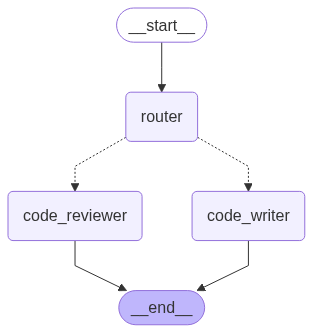

In [4]:
workflow = StateGraph(AgentState)
workflow.add_node("router", router)
workflow.add_node("code_writer", code_writer)
workflow.add_node("code_reviewer", code_reviewer)

workflow.set_entry_point("router")

workflow.add_conditional_edges(
    "router",
    lambda state: state["next_node"],
    {
        "code_writer": "code_writer",
        "code_reviewer": "code_reviewer",
    },
)

workflow.add_edge("code_writer", END)
workflow.add_edge("code_reviewer", END)

graph = workflow.compile()
Image(graph.get_graph().draw_mermaid_png())

In [5]:
question = "Write a Python function that takes a list of integers and returns a new list with only the even numbers."
result = graph.invoke({"question": question})

Markdown(result["response"])

---ROUTING REQUEST---
---ROUTING DECISION: code_writer---
---CALLING CODE WRITER---


```python
def get_even_numbers(numbers):
    """
    Filters a list of integers and returns a new list containing only the even numbers.

    Args:
        numbers (list): A list of integers.

    Returns:
        list: A new list containing only the even numbers from the input list.
             Returns an empty list if the input list is empty or contains no even numbers.
    """
    even_numbers = [number for number in numbers if number % 2 == 0]
    return even_numbers
```

In [6]:
code_to_review = """
def add(a, b):
    # This function has a potential bug with types
    return a + b

print(add("2", 3)) # This will cause a TypeError
"""
question = f"Can you review this piece of code for me? It seems to have a bug.\n\n```python\n{code_to_review}\n```"
result = graph.invoke({"question": question})

Markdown(result["response"])

---ROUTING REQUEST---
---ROUTING DECISION: code_reviewer---
---CALLING CODE REVIEWER---


Okay, I've reviewed the Python code. Here's my assessment:

*   **Bug:** The code does indeed have a potential bug. The `add` function doesn't explicitly handle different data types. When you call `add("2", 3)`, it attempts to add a string and an integer, which results in a `TypeError`.
*   **Type Handling:** The comment "This function has a potential bug with types" is accurate and highlights the issue. Consider adding type checking or casting to handle different input types gracefully, depending on the intended behavior.
*   **Clarity:** The code is simple and easy to understand. The comment is helpful in pointing out the potential problem.
*   **Improvement Suggestion:** To fix the bug, you could cast both arguments to integers or floats before adding them, but this depends on the intended use of the add function. Alternatively, you could raise a TypeError if incompatible types are passed.

Here's an example of handling the potential TypeError with type casting (assuming the intention is numerical addition):

```python
def add(a, b):
    """Adds two numbers, attempting to convert them to integers if possible."""
    try:
        a = int(a)
        b = int(b)
    except ValueError:
        raise TypeError("Inputs must be convertible to integers.")
    return a + b

print(add("2", 3))
```

Or, if string concatenation is desired:

```python
def add(a, b):
    """Adds two values, converting them to strings and concatenating."""
    return str(a) + str(b)

print(add("2", 3))
```

Choose the solution that best fits the function's intended purpose.